# Imports

In [1]:
config = {
    'dhdt': {
        'depth': 3,
        'learning_rate': 1e-3,
        
        'loss': 'binary_crossentropy',#'mae',
        'optimizer': 'adam',        
        
        'beta_1': 100,
        'beta_2': 100,
        
        'squeeze_factor': 1,
        
        'batch_size': 512,
        'epochs': 1_000,
        'early_stopping_epochs': 20,
    },
    
    
    
    'make_classification': {
        'number_of_variables': 5,
        'n_samples': 10_000,
    },

    'computation': {
        'random_seed': 42,
        'num_eval': 5,
        'trials': 1,
        'n_jobs': 40,
        'verbosity': 0,
    },
}



In [2]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '' #'true'

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities import *
from utilities.DHDT import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy

# Evaluation

## make_classification

In [3]:
parallel_eval_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
evaluation_results_synthetic = parallel_eval_synthetic(delayed(evaluate_synthetic_parallel)(index = index,
                                                                                            random_seed_data = config['computation']['random_seed']+index,
                                                                                            random_seed_model = config['computation']['random_seed'],#+random_seed_model,
                                                                                            config = config,
                                                                                            verbosity = -1) for index in range(config['computation']['num_eval']))

for i, synthetic_result in enumerate(evaluation_results_synthetic):
    if i == 0:
        model_dict_synthetic = synthetic_result[0]
        scores_dict_synthetic = synthetic_result[1]
        dataset_dict_synthetic = synthetic_result[2]
    else: 
        model_dict_synthetic = mergeDict(model_dict_synthetic, synthetic_result[0])
        scores_dict_synthetic = mergeDict(scores_dict_synthetic, synthetic_result[1])
        dataset_dict_synthetic = mergeDict(dataset_dict_synthetic, synthetic_result[2])

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=40)]: Done   5 out of   5 | elapsed:  3.5min finished


In [4]:
metrics = ['accuracy_test']
index = [i for i in range(config['computation']['num_eval'])]
columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])

scores_DHDT = [scores_dict_synthetic[i]['DHDT'][metrics[0]] for i in range(config['computation']['num_eval'])]

scores_sklearn = [scores_dict_synthetic[i]['sklearn'][metrics[0]] for i in range(config['computation']['num_eval'])]


scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn
                        
scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn
                        
scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['num_eval'])
scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['num_eval'])

results_DHDT = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
results_sklearn = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])


scores_dataframe_synthetic = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
display(scores_dataframe_synthetic)
display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[1::3]])
display(scores_dataframe_synthetic.describe())

,DHDT accuracy_test_mean,DHDT accuracy_test_max,DHDT accuracy_test_std,sklearn accuracy_test_mean,sklearn accuracy_test_max,sklearn accuracy_test_std
0,0.6235,0.6235,0.0,0.9050,0.9050,0.0
1,0.8365,0.8365,0.0,0.8720,0.8720,0.0
2,0.7700,0.7700,0.0,0.8445,0.8445,0.0
3,0.7320,0.7320,0.0,0.8130,0.8130,0.0
4,0.6280,0.6280,0.0,0.8255,0.8255,0.0


,DHDT accuracy_test_max,sklearn accuracy_test_max
0,0.6235,0.9050
1,0.8365,0.8720
2,0.7700,0.8445
3,0.7320,0.8130
4,0.6280,0.8255


,DHDT accuracy_test_mean,DHDT accuracy_test_max,DHDT accuracy_test_std,sklearn accuracy_test_mean,sklearn accuracy_test_max,sklearn accuracy_test_std
count,5.000000,5.000000,5.0,5.000000,5.000000,5.0
mean,0.718000,0.718000,0.0,0.852000,0.852000,0.0
std,0.092158,0.092158,0.0,0.037042,0.037042,0.0
min,0.623500,0.623500,0.0,0.813000,0.813000,0.0
25%,0.628000,0.628000,0.0,0.825500,0.825500,0.0
50%,0.732000,0.732000,0.0,0.844500,0.844500,0.0
75%,0.770000,0.770000,0.0,0.872000,0.872000,0.0
max,0.836500,0.836500,0.0,0.905000,0.905000,0.0


## Real-World Eval

In [5]:
identifier_list = [
                    'Adult',#: 32,
                    'Bank Marketing',#: 32,
                    'Loan Credit',#: 32,

                    'Credit Card',#: 23, 
                    'Car',#: 21,


                    'Absenteeism',#: 15,
                    'Loan House',#: 15,
                    'Cervical Cancer',#: 15,

                    'Heart Disease',#: 13,           

                    'Titanic',#: 10,
                    'Medical Insurance',#: 10,
                    'Wisconsin Breast Cancer Original',#: 10,
                    'Wisconsin Diagnostic Breast Cancer',#: 10,
                    'Wisconsin Prognostic Breast Cancer',#: 10,
                    'Abalone',#: 10,

                    'Habermans Survival',#: 3, 
                  ]

#identifier_list = ['Habermans Survival']

parallel_eval_real_world = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
evaluation_results_real_world = parallel_eval_real_world(delayed(evaluate_real_world_parallel)(identifier_list=identifier_list, 
                                                                                               random_seed_model=config['computation']['random_seed']+i,
                                                                                               config = config,
                                                                                               verbosity = -1) for i in range(config['computation']['trials']))


for i, real_world_result in enumerate(evaluation_results_real_world):
    if i == 0:
        model_dict_real_world = real_world_result[0]
        scores_dict_real_world = real_world_result[1]
        dataset_dict_real_world = real_world_result[2]
    else: 
        model_dict_real_world = mergeDict(model_dict_real_world, real_world_result[0])
        scores_dict_real_world = mergeDict(scores_dict_real_world, real_world_result[1])
        dataset_dict_real_world = mergeDict(dataset_dict_real_world, real_world_result[2])

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:   35.8s finished


In [6]:
metrics = ['accuracy_test']
index = identifier_list
columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])

scores_DHDT = [scores_dict_real_world[identifier]['DHDT'][metrics[0]] for identifier in identifier_list]

scores_sklearn = [scores_dict_real_world[identifier]['sklearn'][metrics[0]] for identifier in identifier_list]

scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn
                        
scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn
                        
scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

results_DHDT = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
results_sklearn = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])


scores_dataframe_real_world = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
display(scores_dataframe_real_world)
display(scores_dataframe_real_world[scores_dataframe_real_world.columns[1::3]])


,DHDT accuracy_test_mean,DHDT accuracy_test_max,DHDT accuracy_test_std,sklearn accuracy_test_mean,sklearn accuracy_test_max,sklearn accuracy_test_std
0,0.6235,0.6235,0.0,0.9050,0.9050,0.0
1,0.8365,0.8365,0.0,0.8720,0.8720,0.0
2,0.7700,0.7700,0.0,0.8445,0.8445,0.0
3,0.7320,0.7320,0.0,0.8130,0.8130,0.0
4,0.6280,0.6280,0.0,0.8255,0.8255,0.0


,DHDT accuracy_test_max,sklearn accuracy_test_max
0,0.6235,0.9050
1,0.8365,0.8720
2,0.7700,0.8445
3,0.7320,0.8130
4,0.6280,0.8255


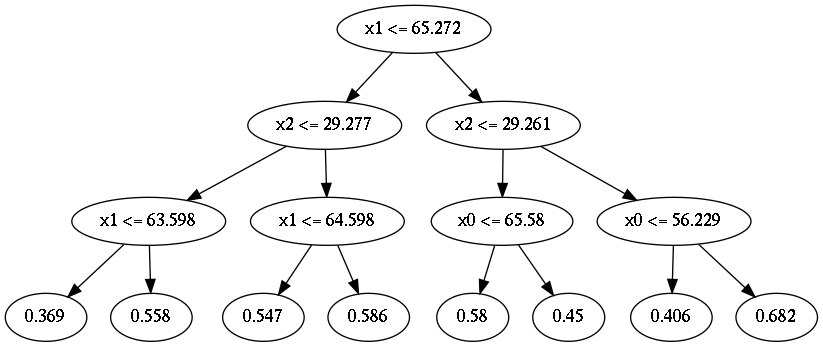

<Figure size 1080x576 with 0 Axes>

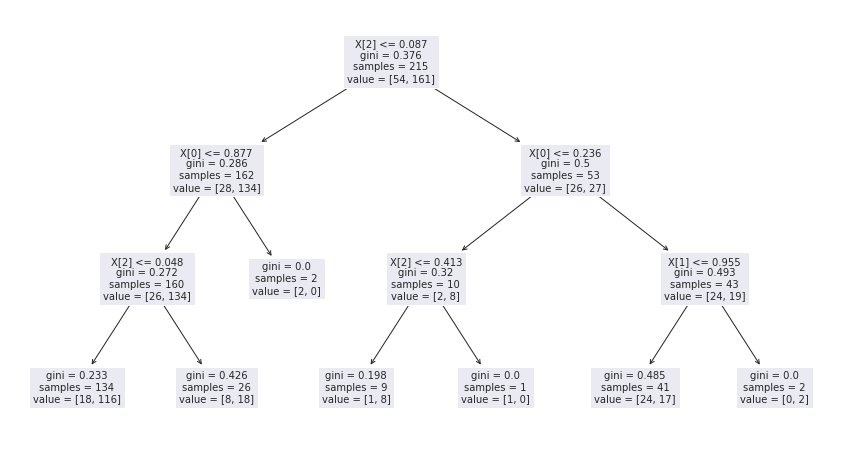

In [7]:
identifier = identifier_list[0]#"Absenteeism"
plt.figure(figsize=(15,8))
image = model_dict_real_world[identifier]['DHDT'].plot(normalizer_list=dataset_dict_real_world[identifier]['normalizer_list'])
display(image)

plt.figure(figsize=(15,8))
plot_tree(model_dict_real_world[identifier]['sklearn'], fontsize=10) 
plt.show()

# Hyperparameter Optimization

In [8]:
parameter_dict = {
        'depth': [3],
        'learning_rate': [0.05, 0.01],#[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
        
        'loss': ['binary_crossentropy'],#['binary_crossentropy', 'rmse'],#'mae',
        'optimizer': ['adam'],#['adam', 'sgd'],        
        
        'beta_1': [10, 50],#[10, 50, 100],
        'beta_2': [10, 50],#[10, 50, 100],
        
        'squeeze_factor': [1],#[0.2, 0.5, 1, 2, 5],    
}

parameter_grid = ParameterGrid(parameter_dict)

In [9]:
def evaluate_parameter_setting_synthetic(parameter_setting):
    
    config_parameter_setting = deepcopy(config)
    
    
    for key, value in parameter_setting.items():
        config_parameter_setting[key] = value
    
    
    
    
    
    parallel_eval_synthetic = Parallel(n_jobs=1, verbose=0, backend='sequential') #loky #sequential multiprocessing
    evaluation_results_synthetic = parallel_eval_synthetic(delayed(evaluate_synthetic_parallel)(index = index,
                                                                                                random_seed_data = config['computation']['random_seed']+index,
                                                                                                random_seed_model = config['computation']['random_seed'],#+random_seed_model,
                                                                                                config = config_parameter_setting,
                                                                                                verbosity = -1) for index in range(config['computation']['num_eval']))

    
    for i, synthetic_result in enumerate(evaluation_results_synthetic):
        if i == 0:
            model_dict_synthetic = synthetic_result[0]
            scores_dict_synthetic = synthetic_result[1]
            dataset_dict_synthetic = synthetic_result[2]
        else: 
            model_dict_synthetic = mergeDict(model_dict_synthetic, synthetic_result[0])
            scores_dict_synthetic = mergeDict(scores_dict_synthetic, synthetic_result[1])
            dataset_dict_synthetic = mergeDict(dataset_dict_synthetic, synthetic_result[2])    
    
    metrics = ['accuracy_valid']
    index = [i for i in range(config['computation']['num_eval'])]
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])

    scores_DHDT = [scores_dict_synthetic[i]['DHDT'][metrics[0]] for i in range(config['computation']['num_eval'])]

    scores_sklearn = [scores_dict_synthetic[i]['sklearn'][metrics[0]] for i in range(config['computation']['num_eval'])]

    scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
    scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

    scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
    scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

    scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['num_eval'])
    scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['num_eval'])

    results_DHDT = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
    results_sklearn = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])


    scores_dataframe_synthetic = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
    #display(scores_dataframe_synthetic)
    #display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[1::3]])
    #display(scores_dataframe_synthetic.describe())    
    
    return np.mean(scores_DHDT_mean), parameter_setting
    
    
 

In [17]:
def evaluate_parameter_setting_real_world(parameter_setting, identifier):
    
    config_parameter_setting = deepcopy(config)
    
    
    for key, value in parameter_setting.items():
        config_parameter_setting[key] = value
    
    
    
    parallel_eval_real_world = Parallel(n_jobs=1, verbose=0, backend='sequential') #loky #sequential multiprocessing
    evaluation_results_real_world = parallel_eval_real_world(delayed(evaluate_real_world_parallel)(identifier_list=[identifier], 
                                                                                                   random_seed_model=config['computation']['random_seed']+i,
                                                                                                   config = config_parameter_setting,
                                                                                                   verbosity = -1) for i in range(config['computation']['trials']))


    for i, real_world_result in enumerate(evaluation_results_real_world):
        if i == 0:
            model_dict_real_world = real_world_result[0]
            scores_dict_real_world = real_world_result[1]
            dataset_dict_real_world = real_world_result[2]
        else: 
            model_dict_real_world = mergeDict(model_dict_real_world, real_world_result[0])
            scores_dict_real_world = mergeDict(scores_dict_real_world, real_world_result[1])
            dataset_dict_real_world = mergeDict(dataset_dict_real_world, real_world_result[2])    
    
    
    metrics = ['accuracy_valid']
    index = [identifier]
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])

    scores_DHDT = [scores_dict_real_world[identifier]['DHDT'][metrics[0]] for identifier in [identifier]]

    scores_sklearn = [scores_dict_real_world[identifier]['sklearn'][metrics[0]] for identifier in [identifier]]

    scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
    scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

    scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
    scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

    scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
    scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
    
    results_DHDT = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
    results_sklearn = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

    scores_dataframe_real_world = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
    #display(scores_dataframe_real_world)
    #display(scores_dataframe_real_world[scores_dataframe_real_world.columns[1::3]])    
    
    
    return np.mean(scores_DHDT_mean), parameter_setting
    
    

In [11]:
parallel_hpo_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
evaluation_results_hpo_synthetic = parallel_hpo_synthetic(delayed(evaluate_parameter_setting_synthetic)(parameter_setting) for parameter_setting in parameter_grid)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of   8 | elapsed: 10.0min remaining: 10.0min
[Parallel(n_jobs=40)]: Done   8 out of   8 | elapsed: 11.9min finished


In [12]:
sorted_evaluation_results_hpo_synthetic = sorted(evaluation_results_hpo_synthetic, key=lambda x: x[0], reverse=True)

In [13]:
print(sorted_evaluation_results_hpo_synthetic[:5])

[(0.7762, {'beta_1': 50, 'beta_2': 10, 'depth': 3, 'learning_rate': 0.01, 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'squeeze_factor': 1}), (0.7273999999999999, {'beta_1': 10, 'beta_2': 50, 'depth': 3, 'learning_rate': 0.05, 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'squeeze_factor': 1}), (0.726, {'beta_1': 10, 'beta_2': 10, 'depth': 3, 'learning_rate': 0.05, 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'squeeze_factor': 1}), (0.726, {'beta_1': 10, 'beta_2': 10, 'depth': 3, 'learning_rate': 0.01, 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'squeeze_factor': 1}), (0.726, {'beta_1': 50, 'beta_2': 10, 'depth': 3, 'learning_rate': 0.05, 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'squeeze_factor': 1})]


In [18]:
identifier = 'Titanic'

parallel_hpo_real = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
evaluation_results_hpo_real = parallel_hpo_real(delayed(evaluate_parameter_setting_real_world)(parameter_setting, identifier) for parameter_setting in parameter_grid)


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of   8 | elapsed:   26.7s remaining:   26.7s
[Parallel(n_jobs=40)]: Done   8 out of   8 | elapsed:   26.8s finished


In [ ]:
sorted_evaluation_results_hpo_real = sorted(evaluation_results_hpo_real, key=lambda x: x[0], reverse=True)

In [ ]:
print(sorted_evaluation_results_hpo_real[:5])